In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import atlite
import rasterio
import pypsa
import os
import yaml
import re
from matplotlib.lines import Line2D

with open('../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
country_longname = {
    "MM": "Myanmar",
    "TH": "Thailand",
    "MY": "Malaysia",
    "LA": "Laos",
    "SG": "Singapore",
    "KH": "Cambodia",
    "VN": "Vietnam",
    "BN": "Brunei",
    "PH": "Philippines",
    "ID": "Indonesia",
    "Peninsular/MY": "Malay Peninsular (M)",
    "Sumatra/ID": "Sumatra (I)",
    "Java-Bali/ID": "Java-Bali (I)",
    "Sarawak/MY":  "Sarawak (M)",
    "Kalimantan/ID": "Kalimantan (I)",
    "Sabah/MY": "Sabah (M)",
    "Nusa-Tenggara/ID": "Nusa-Tenggara (I)",
    "Sulawesi/ID": "Sulawesi (I)",
    "Maluku/ID": "Maluku (I)",
    "Papua/ID": "West Papua (I)"
    }

country_prefered_order = ['Myanmar', 'Thailand', 'Sumatra (I)', 'Malay Peninsular (M)','Singapore', 'Laos', 'Cambodia', 'Vietnam', 'Java-Bali (I)',
                          'Kalimantan (I)', 'Sarawak (M)', 'Brunei', 'Sabah (M)','Nusa-Tenggara (I)', 'Sulawesi (I)', 'Philippines', 'Maluku (I)',
                          'West Papua (I)']

preferred_order = pd.Index(
    [
        "transmission lines",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "onshore wind",
        "offshore wind ac",
        "offshore wind dc",
        "solar PV",
        "solar thermal",
        "OCGT",
        "hydrogen storage",
        "battery storage",
    ]
)

def add_and_rename_countries(df):
    for i in list(country_longname.keys() - set(df.index)):
        df.loc[i] = pd.Series().fillna(0)

    # convert abbreviation into nice long names
    df["Countries"] = [country_longname[c] for c in df.index]
    df = df.set_index("Countries")

    return df

def rename_techs(label):
    if "H2" in label:
        label = "hydrogen storage"
    elif label == "solar":
        label = "solar PV"
    elif label == "offwind-ac":
        label = "offshore wind ac"
    elif label == "offwind-dc":
        label = "offshore wind dc"
    elif label == "onwind":
        label = "onshore wind"
    elif label == "ror":
        label = "hydroelectricity"
    elif label == "hydro":
        label = "hydroelectricity"
    elif label == "PHS":
        label = "hydroelectricity"
    elif "battery" in label:
        label = "battery storage"

    return label

In [189]:
def calculate_plot_LCOE(n,weather_year):
    fossil_fuel = ["nuclear", "oil", "OCGT", "CCGT", "coal", "coal-SubC", "coal-SC", "coal-USC", "coal-CFB", "lignite", "geothermal", "biomass"]
    renewable = [ "offwind-dc", "offwind-ac","onwind", "solar"]
    
    df_gen = pd.DataFrame(index=n.generators.index)
    df_gen["carrier"] = n.generators.carrier
    df_gen["country"] = n.generators.bus.map(n.buses.country)
    df_gen["p_max"] = n.generators.p_nom_max
    df_gen["p_max_pu"] = n.snapshot_weightings.generators @ n.generators_t.p_max_pu
    df_gen["p_max_pu"] = df_gen["p_max_pu"].fillna(0)
    df_gen["p_max_pu"] = [8760 if df_gen.loc[i,"carrier"] in fossil_fuel else df_gen.loc[i,"p_max_pu"] for i in df_gen.index]
    df_gen["e_max"] = df_gen["p_max"] * df_gen["p_max_pu"]
    
    df_gen["lcoe_max"] = n.generators.capital_cost/(df_gen["p_max_pu"]) + n.generators.marginal_cost
    df_gen["lcoe_actual"] = n.generators.capital_cost/(n.snapshot_weightings.generators @ n.generators_t.p/n.generators.p_nom_opt) + n.generators.marginal_cost
    
    df_gen["lcoe_max_e"] = df_gen["lcoe_max"] * df_gen["e_max"]
    df_gen["lcoe_actual_e"] = df_gen["lcoe_actual"] * df_gen["e_max"]

    df_LCOE = pd.DataFrame(columns=renewable + [f"{r}_cap" for r in renewable], index=n.buses.country.unique())
    refactor = 1e7
    
    for country in df_LCOE.index:
        for carrier in renewable:
            df_LCOE.loc[country,f"{carrier}_cap"] = df_gen.query("country == @country & carrier == @carrier").e_max.sum() / refactor
            df_LCOE.loc[country,carrier] = df_gen.query("country == @country & carrier == @carrier").lcoe_max_e.sum()/df_gen.query("country == @country & carrier == @carrier").e_max.sum()
    
    df_LCOE = df_LCOE.fillna(1e9)
    df_LCOE = add_and_rename_countries(df_LCOE)
    
    new_index_order = [c for c in country_prefered_order if c in df_LCOE.index]
    df_LCOE = df_LCOE.loc[new_index_order]

    fig, ax = plt.subplots(figsize=(6,4))

    df_LCOE["index"] = range(18)

    df_plot = pd.DataFrame()
    
    for r in renewable:
        df = df_LCOE.loc[:,[r, f"{r}_cap","index"]]
        df["color"] = config["plotting"]["tech_colors"][r]
        df = df.rename(columns={r:"LCOE", f"{r}_cap":"cap"})
        if df_plot.empty:
            df_plot = df
        else:
            df_plot = pd.concat([df_plot,df])

    scatter = ax.scatter(df_plot["index"],df_plot["LCOE"],s=df_plot["cap"],c=df_plot["color"])
    
    #df_plot.plot.scatter(x="index", y="LCOE", s="cap",ax=ax, c="color")
    
    #for r in renewable:
    #    df_LCOE.plot.scatter(x="index", y=r, s=f"{r}_cap",ax=ax, color=config["plotting"]["tech_colors"][r])
        
    ax.set_ylim([0, 500])
    plt.xticks(range(18), df_LCOE.index, rotation=90)
    ax.grid(axis="y")
    #ax.grid(axis="x")
    ax.set_xlabel("")
    ax.set_ylabel("LCOE [€/kWh]")
    
    df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.carrier.unique()]}, index = n.generators.carrier.unique())
    
    df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()
    
    df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))
    
    df_color = df_color.loc[["solar PV","onshore wind","offshore wind ac","offshore wind dc"],:]
    
    #pypsa.plot.add_legend_patches(ax=ax, colors = [n.carriers.loc[c,"color"] for c in n.generators.carrier.unique()], labels = n.generators.carrier.unique())
    pypsa.plot.add_legend_patches(ax=ax, colors = df_color.color, labels = df_color.index,
                                 legend_kw = {'loc':"lower center",'bbox_to_anchor':(0.6, 1), 'frameon':False, 'ncol':4, 'title':"Renewable Carrier", 
                                              'title_fontproperties':{'weight':'bold'}})
    
    elec_demand = (n.snapshot_weightings.generators @ n.loads_t.p).sum()

    #handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
    #legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
    
    #legend_bus = {"sizes":[1e8/refactor, (5 * 1e8)/refactor],#,  df_LCOE.sum()["solar_cap"], elec_demand/refactor, df_LCOE.sum()["onwind_cap"]],
    #              "labels":["100 TWh/a","500 TWh/a"]#, "Total SEA\nSolar Potential", "Total SEA\n2050 Energy \nDemand", "Total SEA\nOnshore Wind \nPotential"]
    #             }

    MWh_to_TWh = 1e6

    legend_bus = {"sizes":[10, 100, 500, df_LCOE.sum()["solar_cap"], elec_demand/refactor, df_LCOE.sum()["onwind_cap"]],
                  "labels":["100 TWh/a", "1000 TWh/a", "5000 TWh/a", "Total SEA\nSolar Potential", "Total SEA\n2050 Energy \nDemand", "Total SEA\nOnshore Wind \nPotential"],
                  "color":["silver", "silver", "silver", config["plotting"]["tech_colors"]["solar"],"black",config["plotting"]["tech_colors"]["onwind"]]
                 }
    
    legend_bus["sizes_sqrt"] = list(map(lambda x:x ** (1/2), legend_bus["sizes"]))

    legend_elements = [Line2D([0], [0], marker='o', color='w', label=legend_bus["labels"][i],
                              markerfacecolor=legend_bus["color"][i], markersize=legend_bus["sizes_sqrt"][i]) for i in range(len(legend_bus["sizes"]))]
    
    legend2 = ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.005, 0.5),
                        frameon=False, labelspacing=1.5, title="Energy Potential \n [TWh/a]",
                        title_fontproperties={'weight':'bold'})

    ax.set_title(f'ERA5 weather year: {weather_year}',loc='left',x=0.02,y=0.9,fontsize=9)

    if not os.path.exists(f'Figures/LCOE'):
        os.mkdir(f'Figures/LCOE')

    plt.savefig(f'Figures/LCOE/LCOE_weather_year_{weather_year}.svg',bbox_inches='tight')

    return df_LCOE


# Check Renewable LCOE

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


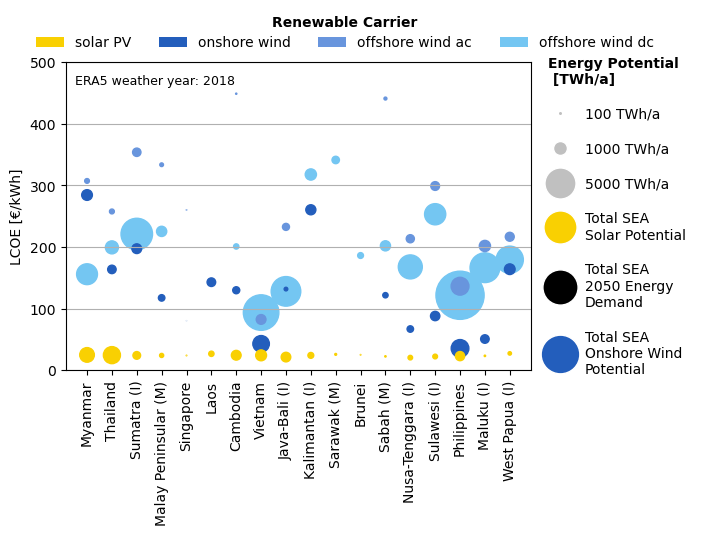

In [190]:
scenarios = ["SEA_AIMS_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

weather_year = 2018

for scenario in scenarios:
    df = calculate_plot_LCOE(fn[scenario], weather_year)

In [135]:
df

,offwind-dc,offwind-ac,onwind,solar,offwind-dc_cap,offwind-ac_cap,onwind_cap,solar_cap,index
Countries,,,,,,,,,
Myanmar,1.559608e+02,3.073913e+02,284.518624,24.951640,225.478981,11.622766,59.355787,111.019456,0
Thailand,1.995281e+02,2.578156e+02,163.754189,24.579054,87.654465,12.322142,37.255781,150.962452,1
Sumatra (I),2.211885e+02,3.539298e+02,197.377853,24.135298,514.892481,36.275354,49.010478,30.586840,2
Malay Peninsular (M),2.254838e+02,3.336697e+02,117.526826,24.094034,54.217502,7.091533,21.894686,8.808893,3
Singapore,1.000000e+09,2.603210e+02,80.488208,23.997829,0.000000,0.113098,0.004860,0.198540,4
Laos,1.000000e+09,1.000000e+09,142.986328,26.771830,0.000000,0.000000,38.402314,14.682105,5
Cambodia,2.009900e+02,4.489746e+02,129.917479,24.416941,14.386190,0.811122,25.689490,49.236228,6
Vietnam,9.368921e+01,8.252731e+01,42.959543,24.230198,654.609731,48.907134,141.645652,61.305371,7
Java-Bali (I),1.280935e+02,2.327779e+02,131.811030,21.415632,454.067520,25.612926,6.854588,47.852171,8


In [134]:
df.solar_cap.sum() * 1e7/1e6

5689.758152393277

In [105]:
label = 100
for i in range(len(handles)):
    markersize = handles[i].get_markersize()
    print(f"{label}: {markersize}")
    label += 100

# Its the square root of one another

100: 10.0
200: 14.142135623730951
300: 17.320508075688775
400: 20.0
500: 22.360679774997898
600: 24.49489742783178
700: 26.457513110645905
800: 28.284271247461902
900: 30.0
1000: 31.622776601683793
1100: 33.166247903554
1200: 34.64101615137755


In [110]:
100 ** (1/2)

10.0

In [144]:


handles[0].get_markersize()
print(labels)
refactor = 1e7

legend_bus = {"sizes":[1, 10, 100],
              "labels":[ "10 TWh", "100 TWh/a", "1000 TWh/a"]
             }

legend_bus["size_sqrt"] = list(map(lambda x:x ** (1/2), legend_bus["sizes"]))
legend_bus

#legend_elements = [Line2D([0], [0], marker='o', color='w', label=legend_bus["labels"][i], markerfacecolor='g', markersize=legend_bus["sizes"][i]) for i in range(len(legend_bus["sizes"]))]
#print(legend_elements)

['$\\mathdefault{100}$', '$\\mathdefault{200}$', '$\\mathdefault{300}$', '$\\mathdefault{400}$', '$\\mathdefault{500}$', '$\\mathdefault{600}$', '$\\mathdefault{700}$', '$\\mathdefault{800}$', '$\\mathdefault{900}$', '$\\mathdefault{1000}$', '$\\mathdefault{1100}$', '$\\mathdefault{1200}$']


{'sizes': [1.0, 10.0, 100.0],
 'labels': ['10 TWh', '100 TWh/a', '1000 TWh/a'],
 'real_size': [1.0, 3.1622776601683795, 10.0]}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


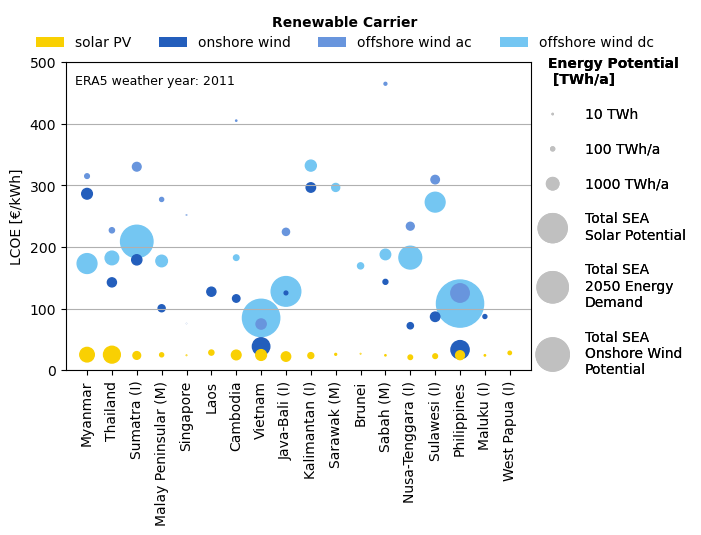

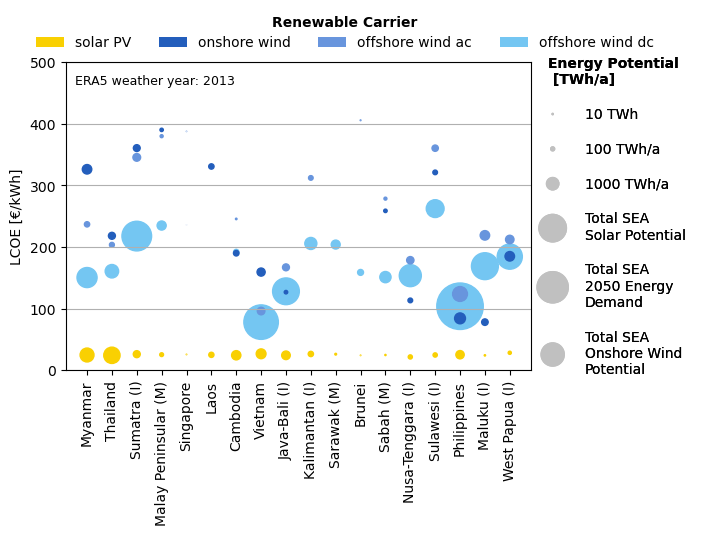

In [12]:
scenarios = ["SEA_ERA5_2011_AIMS_", "SEA_ERA5_2013_AIMS_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

for scenario in scenarios:
    if scenario == "SEA_ERA5_2011_AIMS_":
        weather_year = 2011
    if scenario == "SEA_ERA5_2013_AIMS_":
        weather_year = 2013
    calculate_plot_LCOE(fn[scenario], weather_year)

# Energy Distribution

In [17]:
def energy_distribution(infn_energy, scenario_PyPSA, dec_name):
    fig, (ax) = plt.subplots(figsize=(8, 3))
    df_all = pd.DataFrame()
    
    df_all = pd.DataFrame()
    loads_df_all = pd.DataFrame()
    
    for country in countries:
        energy_df = pd.read_csv(infn_energy[country], index_col=list(range(2)), header=[1, 2, 3])
    
        energy_df.columns = [country]
    
        df = energy_df.groupby(energy_df.index.get_level_values(1)).sum()
    
        loads_df = - energy_df.groupby(energy_df.index.get_level_values(0)).sum().query("index == 'loads'")/ 1e6
    
        # If there is any unique carrier to remove
        if "B2B" in df.index:
            df = df.drop("B2B")
    
        # convert MWh to TWh
        df = df / 1e6
    
        df = df.groupby(df.index.map(rename_techs)).sum()
    
        if df_all.empty:
            df_all = df
        else:
            df_all = pd.concat([df_all,df],axis=1)
    
        if loads_df.empty:
            loads_df_all = loads_df
        else:
            loads_df_all = pd.concat([loads_df_all,loads_df],axis=1)
    
    new_index_energy = df_all.index.intersection(preferred_order).append(
        df.index.difference(preferred_order)
    )
    
    df_all = add_and_rename_countries(df_all.T).T
    
    #new_columns = df_all.columns.sort_values()
    new_columns = [c for c in country_prefered_order if c in df_all.columns]
    
    df_all.loc[new_index_energy, new_columns].T.plot(
        kind="bar",
        width = 0.9,
        ax=ax,
        stacked=True,
        color=[config["plotting"]["tech_colors"][i] for i in new_index_energy],
        rot=90,
        legend=False
    )
    
    loads_df_all = add_and_rename_countries(loads_df_all.T).T
    
    loads_df_all.loc[:, new_columns].T.plot(
        kind="bar",
        ax=ax,
        width = 0.9,
        edgecolor="black",
        linestyle = 'dashed',
        fill=False,
        rot=90,
        legend=False
    )
    
    ax.set_ylim([-200, 2000])
    ax.grid(axis="y")
    ax.set_xlabel("")
    ax.set_ylabel("TWh/a")
    
    df_color = pd.DataFrame(data = {"color" : [n.carriers.loc[c,"color"] for c in n.generators.carrier.unique()]}, index = n.generators.carrier.unique())
    
    df_color = df_color.groupby(df_color.index.map(rename_techs)).sum()
    
    for i in ["hydrogen storage","battery storage"]:
        df_color.loc[i,"color"] = config["plotting"]["tech_colors"][i] 
    
    df_color.index.intersection(preferred_order).append(df_color.index.difference(preferred_order))
    
    df_color = df_color.drop(["coal","coal-CFB","coal-SC","coal-SubC","coal-USC","lignite","oil"])
    
    pypsa.plot.add_legend_patches(ax=ax, colors = df_color.color, labels = df_color.index,
                                 legend_kw = {'loc':"lower center",'bbox_to_anchor':(0.5, 1), 'frameon':False, 'ncol':4, 'title':"Energy Sources", 
                                              'title_fontproperties':{'weight':'bold'}})

    ax.annotate('Regional\nLoad/a',
        xy=(4, loads_df_all["Singapore"]),  # theta, radius
        xytext=(4, loads_df_all["Singapore"]+750),    # fraction, fraction
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth = 5),
        horizontalalignment='center',
        verticalalignment='top',
        )

    ax.set_title(f'{scenario_PyPSA}{dec_name}_2050', 
                 loc='right', 
                 x=0.98, 
                 y=0.88,
                 fontsize=9
                )

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_energy_distribution.svg',bbox_inches='tight')

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


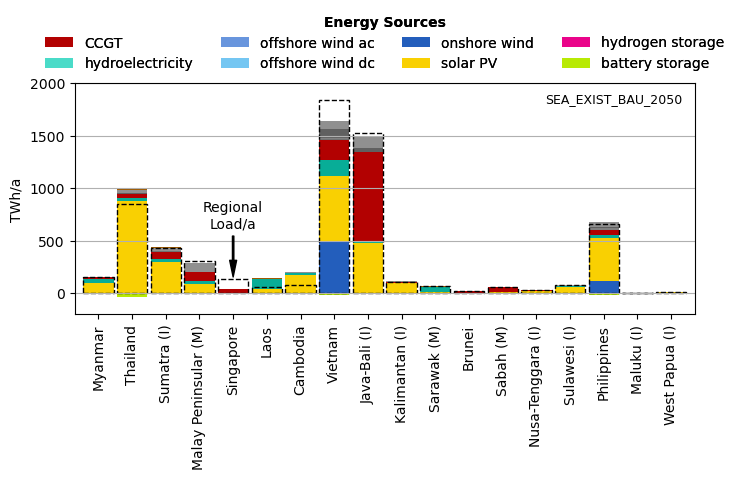

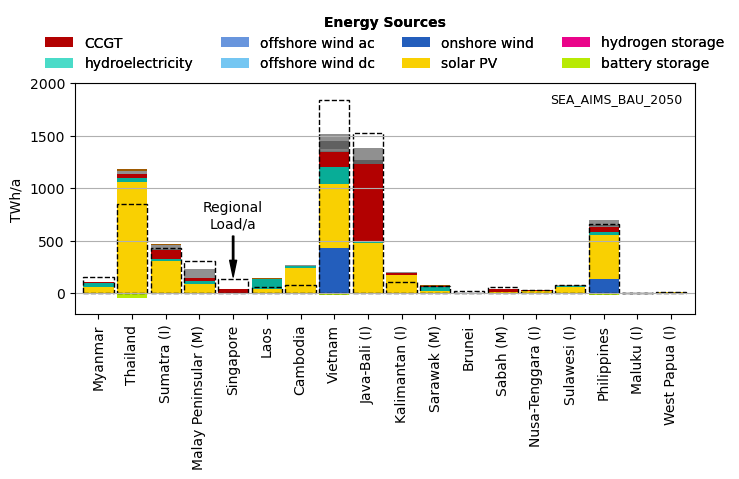

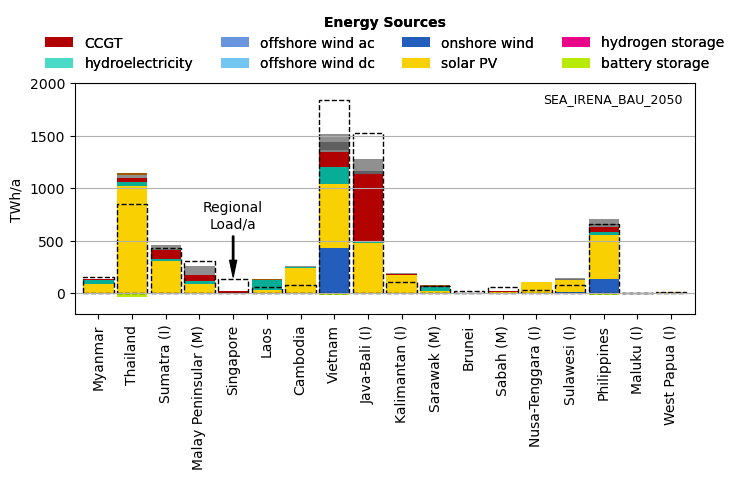

In [18]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

for scenario in scenarios:
    n = fn[scenario]
    countries = n.buses.country.unique()
    infn_energy = {country:f"../{folder_name}/results/{scenario + str(year)}/summaries/{network_name}_{country}/energy.csv" for country in countries}
    energy_distribution(infn_energy, scenario, dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


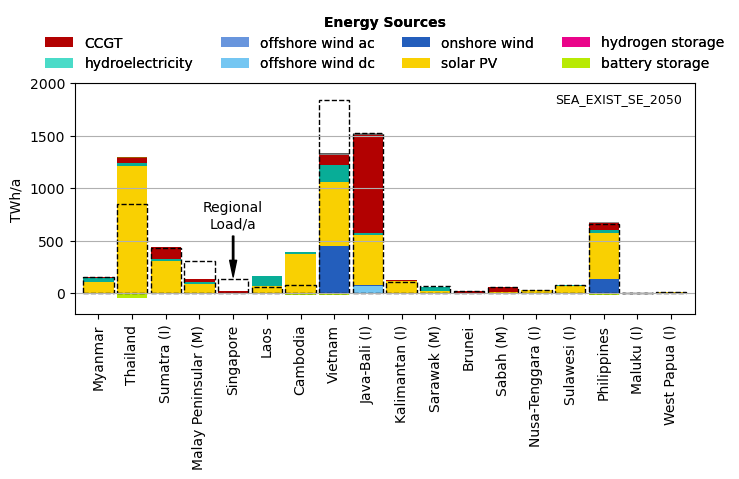

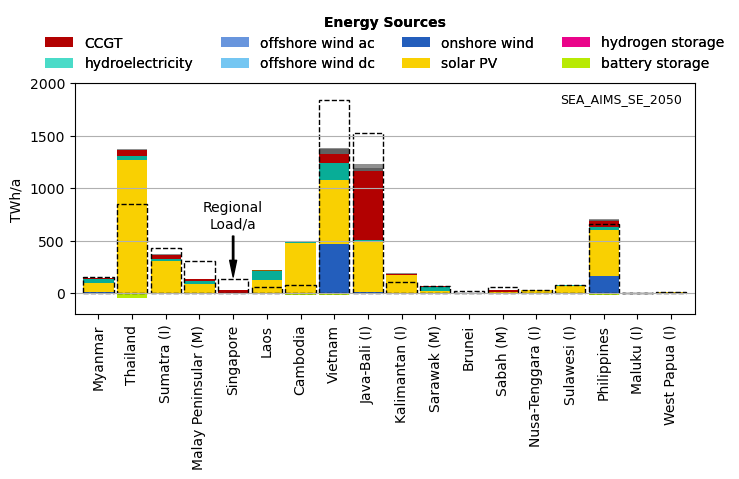

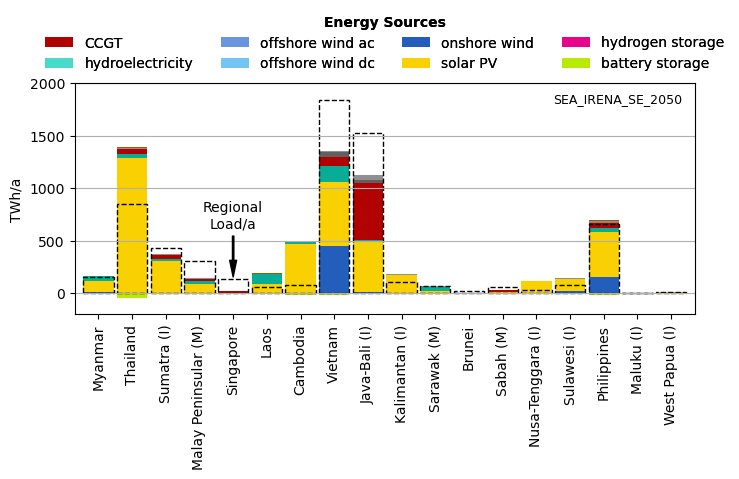

In [19]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.500924-3H"
dec_name = "SE"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

for scenario in scenarios:
    n = fn[scenario]
    countries = n.buses.country.unique()
    infn_energy = {country:f"../{folder_name}/results/{scenario + str(year)}/summaries/{network_name}_{country}/energy.csv" for country in countries}
    energy_distribution(infn_energy, scenario, dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


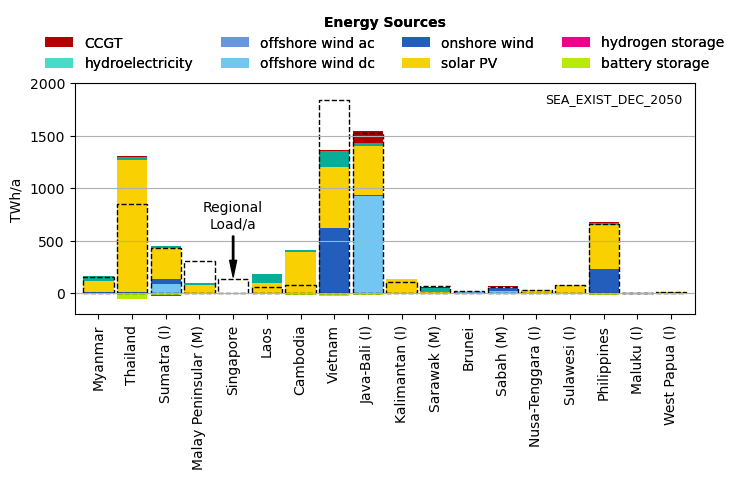

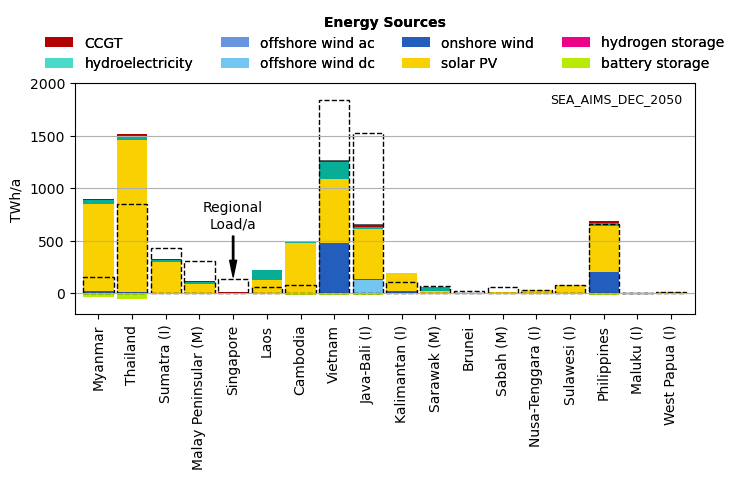

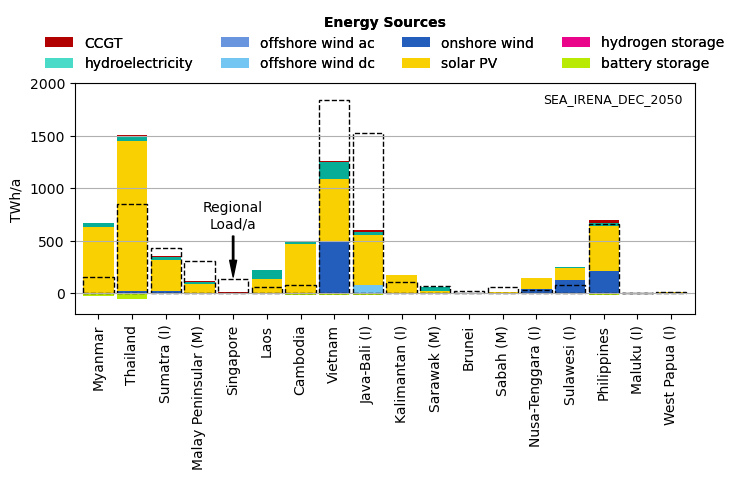

In [20]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

for scenario in scenarios:
    n = fn[scenario]
    countries = n.buses.country.unique()
    infn_energy = {country:f"../{folder_name}/results/{scenario + str(year)}/summaries/{network_name}_{country}/energy.csv" for country in countries}
    energy_distribution(infn_energy, scenario, dec_name)